# Divvy Exploratory Data Analysis

### Preliminaries

In [54]:
import pandas as pd
import os
from datetime import datetime
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [77]:
colours = ['#D5573B','#074F57','#077187','#9ECE9A','#D7CEB2']
sns.set_palette(colours)

In [4]:
dtypes = {
    'ride_id': str,
    'rideable_type': str,
    'started_at': str,
    'ended_at': str,
    'start_station_name': str,
    'start_station_id': str,
    'end_station_name': str,
    'end_station_id': str,
    'start_lat': float,
    'start_lng': float,
    'end_lat': float,
    'end_lng': float,
    'member_casual': str,
    'time': float,
    'distance': float,
}

In [6]:
data_path = os.getcwd() + '/../data/data_dist_time.csv'
data = pd.read_csv(data_path, dtype=dtypes, index_col=0)

In [10]:
data['started_at'] = pd.to_datetime(data['started_at'])
data['ended_at'] = pd.to_datetime(data['ended_at'])
data['time'] = data['time'].div(60)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16031963 entries, 0 to 16048416
Data columns (total 15 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  time                float64       
 14  distance            float64       
dtypes: datetime64[ns](2), float64(6), object(7)
memory usage: 1.9+ GB


In [91]:
data['year'] = data['started_at'].dt.year
data['month'] = data['started_at'].dt.month
data['hour'] = data['started_at'].dt.hour

data.year = data.year.astype('category')
data.month = data.month.astype('category')
data.hour = data.hour.astype('category')

In [92]:
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,time,distance,year,month,hour
0,A847FADBBC638E45,docked_bike,2020-04-26 17:45:14,2020-04-26 18:12:03,Eckhart Park,86,Lincoln Ave & Diversey Pkwy,152,41.8964,-87.6610,41.9322,-87.6586,member,26.816667,2.473894,2020,4,17
1,5405B80E996FF60D,docked_bike,2020-04-17 17:08:54,2020-04-17 17:17:03,Drake Ave & Fullerton Ave,503,Kosciuszko Park,499,41.9244,-87.7154,41.9306,-87.7238,member,8.150000,0.608713,2020,4,17
2,5DD24A79A4E006F4,docked_bike,2020-04-01 17:54:13,2020-04-01 18:08:36,McClurg Ct & Erie St,142,Indiana Ave & Roosevelt Rd,255,41.8945,-87.6179,41.8679,-87.6230,member,14.383333,1.854582,2020,4,17
3,2A59BBDF5CDBA725,docked_bike,2020-04-07 12:50:19,2020-04-07 13:02:31,California Ave & Division St,216,Wood St & Augusta Blvd,657,41.9030,-87.6975,41.8992,-87.6722,member,12.200000,1.330589,2020,4,12
4,27AD306C119C6158,docked_bike,2020-04-18 10:22:59,2020-04-18 11:15:54,Rush St & Hubbard St,125,Sheridan Rd & Lawrence Ave,323,41.8902,-87.6262,41.9695,-87.6547,casual,52.916667,5.666709,2020,4,10


### Further Cleaning

In [22]:
data[['time', 'distance']].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,time,distance
count,1.6032e+07,1.6032e+07
mean,19.347,1.34395
std,207.583,4.48047
min,-29050,0
25%,6.33333,0.541596
50%,11.4,0.999052
75%,20.95,1.77824
max,58720,6100.2


We can remove some outliers, particularly when time is negative or absurdly high. The maximum time is 58,720 minutes—that's over 40 days! Let's filter out the top and bottom percentage of the data in terms of time.

In [93]:
lower = np.percentile(data['time'], 1)
upper = np.percentile(data['time'], 99)
cleaned = data[data.time.between(lower, upper)]
cleaned[['time', 'distance']].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,time,distance
count,1.57164e+07,1.57164e+07
mean,16.6744,1.35589
std,16.6612,4.24871
min,0.333333,0
25%,6.41667,0.559411
50%,11.4,1.01176
75%,20.65,1.7881
max,124.117,6100.2


Looks much better. However, the maximum distance of 6,100 miles is also a bit fishy, especially considering the maximum time is now just over 2 hours. That's nearly 3,000mph, more than five times faster than a commercial plane. Impressive, but probably not realistic. Chicago is about 25 miles at its greatest extent, so let's also filter out data points where the distances exceed 25 miles.

In [94]:
cleaned2 = cleaned[cleaned.distance < 25]
cleaned2[['time', 'distance']].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,time,distance
count,1.57163e+07,1.57163e+07
mean,16.6744,1.35313
std,16.6612,1.20589
min,0.333333,0
25%,6.41667,0.559411
50%,11.4,1.01176
75%,20.65,1.7881
max,124.117,19.8114


<Axes: xlabel='distance', ylabel='Density'>

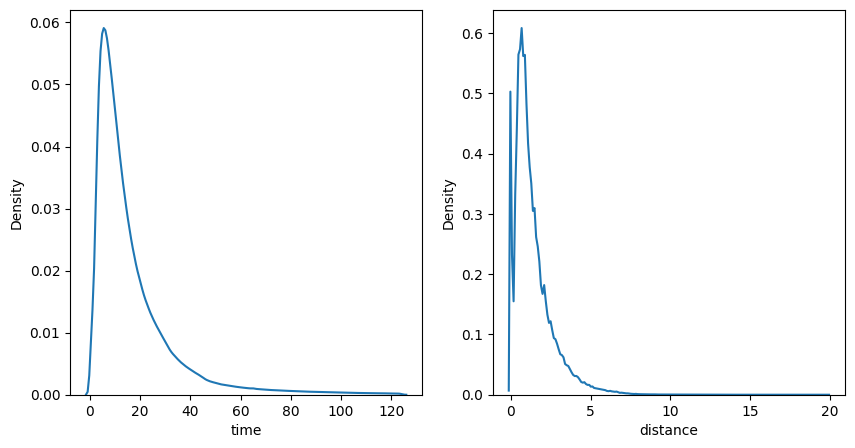

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(data=cleaned2, x='time', ax=axes[0])
sns.kdeplot(data=cleaned2, x='distance', ax=axes[1])

# Analysis

I will perform the following analyses:

<u> Casual vs member analysis </u>
1. Usage time
    - Average time
2. Usage (by hour of day)
3. Usage (by month of year)
4. Distance rode
    - Average distance
5. Popular stations (starting and ending)
6. Bike type
7. Trip count

<u> Inter-year comparisons (zoom in on 2021 vs 2022) </u>
1. Usage time
    - Casual vs member
    - Bike type
2. Popular stations
3. Distance rode
    - Casual vs member
    - Bike type
4. Trip count

<u> Inter-station comparisons </u>
1. Casual vs member
2. Peak hours
3. Peak months
4. Trip count

Much of the analyses will be concentrated on the time rather than the distance as the distance travelled can be somewhat misleading. It is possible that riders pick up and dock at the same station, and the distance travelled metric does not capture this behaviour accurately. Also for this reason, I did not impose a lower bound on distance rode when cleaning the dataset in the previous section.

#### Casual vs member analysis

In [65]:
cleaned2.groupby('member_casual')['time'].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,count,mean,std,min,25%,50%,75%,max
member_casual,,,,,,,,
casual,6.48409e+06,22.1773,21.1826,0.333333,8.46667,15.0333,27.55,124.117
member,9.23225e+06,12.8095,11.01,0.333333,5.51667,9.51667,16.5333,124.117


In [66]:
cleaned2.groupby('member_casual')['distance'].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,count,mean,std,min,25%,50%,75%,max
member_casual,,,,,,,,
casual,6.48409e+06,1.37743,1.24927,0,0.570009,1.05473,1.83324,19.8114
member,9.23225e+06,1.33605,1.17416,0,0.55423,0.978693,1.75399,19.5928


<Axes: xlabel='time', ylabel='Density'>

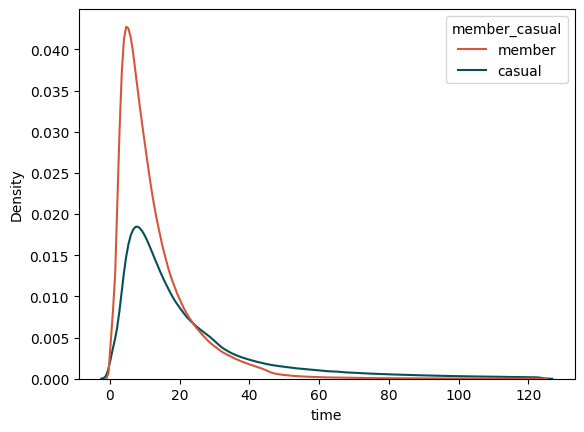

In [89]:
sns.kdeplot(data=cleaned2, x='time', hue='member_casual')

On average, casual riders ride for 10 minutes longer than members, averaging 22 minutes a ride compared to the members' average of 12 minutes. This is apparent in the plot as well, with casual members taking a greater proportion of rides over 20 minutes.

<Axes: xlabel='count', ylabel='month'>

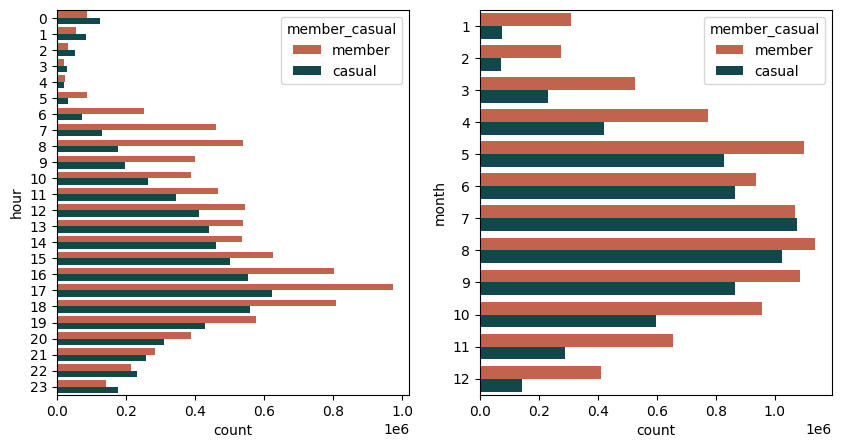

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=cleaned2, y='hour', hue='member_casual', ax=axes[0])
sns.countplot(data=cleaned2, y='month', hue='member_casual', ax=axes[1])